In [15]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert, lfilter, find_peaks, welch, iirnotch
from scipy.integrate import cumtrapz, trapz
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import pywt

In [16]:
def extract_file_Bitalino(file):
    signal = np.genfromtxt(file + ".txt", delimiter="\t")
    signal = signal[:,-2]
    return signal

def tomV_byBitalino(ADC, n = 10, VCC = 3.3):
    volts = (((ADC/(2**n))-(1/2)) * VCC)/1009
    return volts*1000

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def extract_features(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    amplitude = np.max(signal) - np.min(signal)
    fft_signal = np.fft.fft(signal)
    dominant_frequency = np.argmax(np.abs(fft_signal))
    peaks, _ = find_peaks(signal)
    duration = (peaks[-1]-peaks[0])/len(signal)
    power = np.sum(np.square(signal))/len(signal)
    kurtosis = np.sum((signal - mean)**4)/(len(signal)*std**4)
    coeffs = pywt.wavedec(signal, 'db4', level = 5)
    cA5,cD5,cD4,cD3,cD2,cD1 = coeffs
    wavelet = np.concatenate((cD1, cD2, cD3, cD4, cD5))
    rms = np.sqrt(np.sum(signal * signal)/len(signal))
    area = cumtrapz(signal)
    f,P = welch(signal,fs = 1000, window='hann', noverlap=0,nfft = int(256.))
    area_freq = cumtrapz(P,f,initial=0)
    total_power = area_freq[-1]
    median_freq = f[np.where(area_freq > total_power/2)[0][0]]
    f_max = f[np.argmax(P)]
    features =  {'media': mean,
                 'desviacion_estandar': std,
                 'amplitud': amplitude,
                 'frecuencia_dominante': dominant_frequency,
                 'potencia': power,
                 'kurtosis': kurtosis,
                 'wavelet': wavelet,
                 'rms': rms,
                 'area': area,
                 'min_value': np.min(signal),
                 'max_value': np.max(signal),
                 'area_freq': area_freq,
                 'total_power': total_power,
                 'median_freq': median_freq,
                 'f_max': f_max                 
                 }
    return features

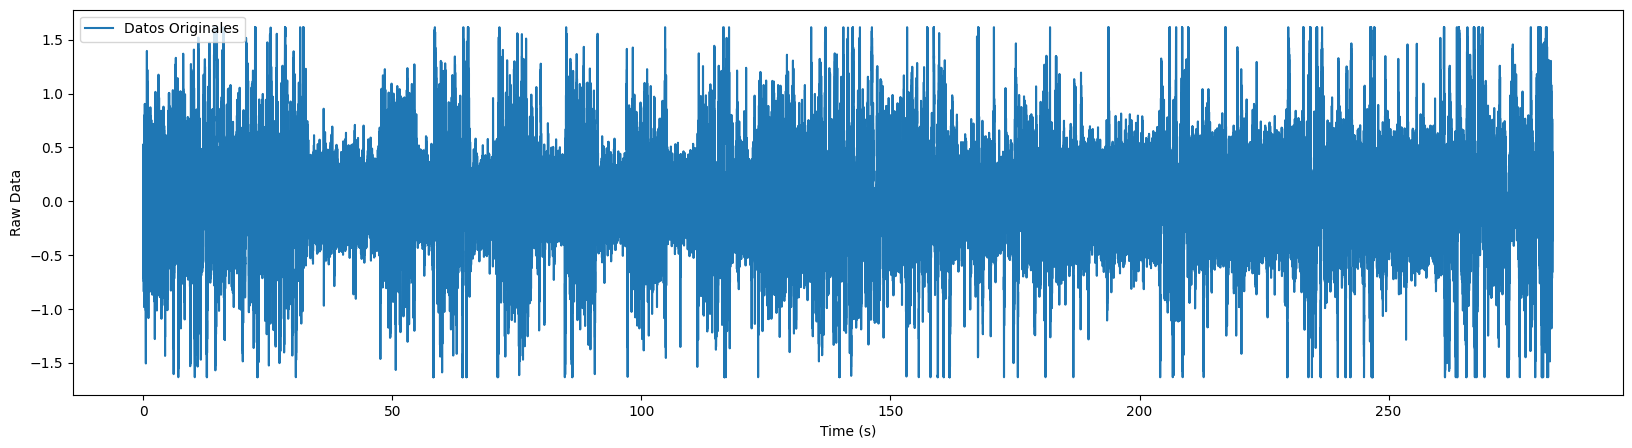

In [17]:
fs = 1000; ts = 1/fs # Bitalino's sampling rate
# Los archivos tomados por Bitalino fueron: Procedimiento.txt y Luz.txt
signal = extract_file_Bitalino('Procedimiento')
signal = tomV_byBitalino(signal)
time = np.arange(len(signal))*ts
plt.figure(figsize=(20,5))
plt.plot(time, signal, label = 'Datos Originales')
plt.ylabel('Raw Data')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

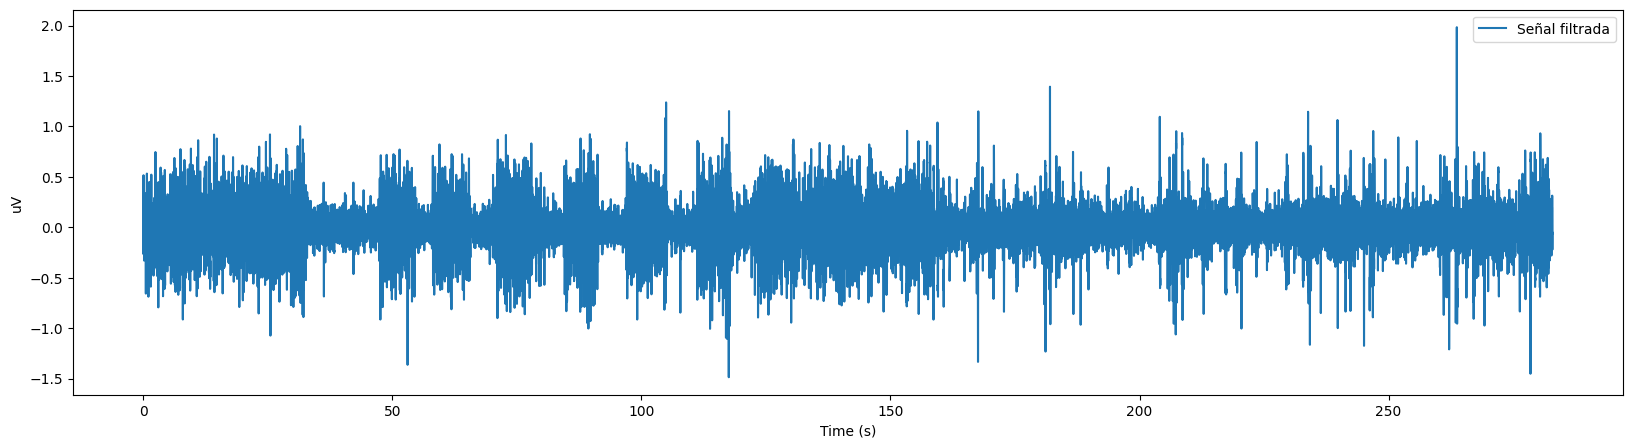

In [18]:
low_cutoff_wide = 3
high_cutoff_wide = 30

filtered_eeg = butter_bandpass_filter(signal, low_cutoff_wide, high_cutoff_wide, fs)

plt.figure(figsize=(20,5))
plt.plot(time, filtered_eeg, label = 'Señal filtrada')
plt.ylabel('uV')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

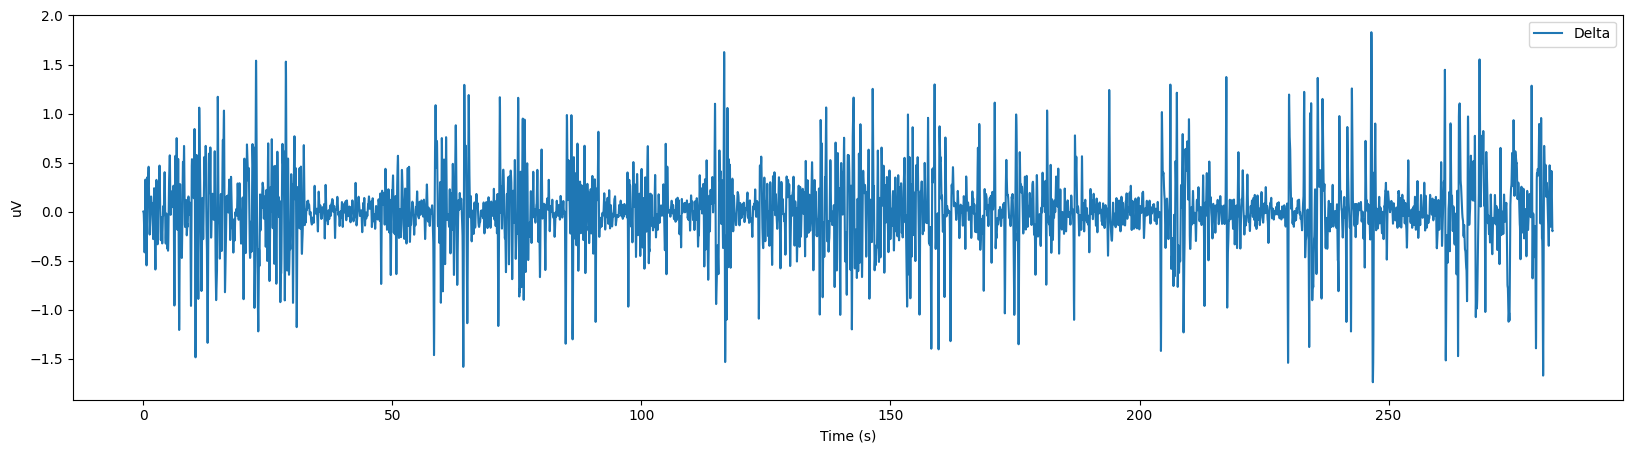

In [19]:
# Extracción de ondas delta:

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # frecuencia de Nyquist
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


low_cutoff_wide = 4

delta = butter_lowpass_filter(signal, low_cutoff_wide, fs)

plt.figure(figsize=(20,5))
plt.plot(time, delta, label = 'Delta')
plt.ylabel('uV')
plt.xlabel('Time (s)')
plt.legend()
plt.show()


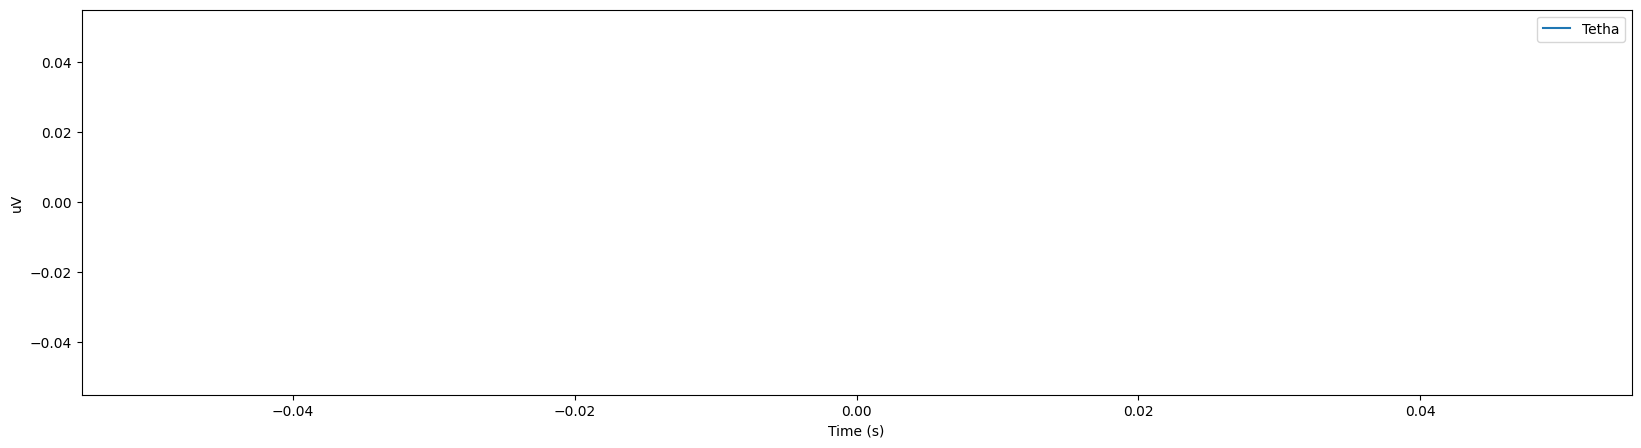

In [20]:
# Extracción de ondas theta:

low_cutoff_wide = 4
high_cutoff_wide = 8

theta = butter_bandpass_filter(signal, low_cutoff_wide, high_cutoff_wide, fs)

plt.figure(figsize=(20,5))
plt.plot(time, theta, label = 'Tetha')
plt.ylabel('uV')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

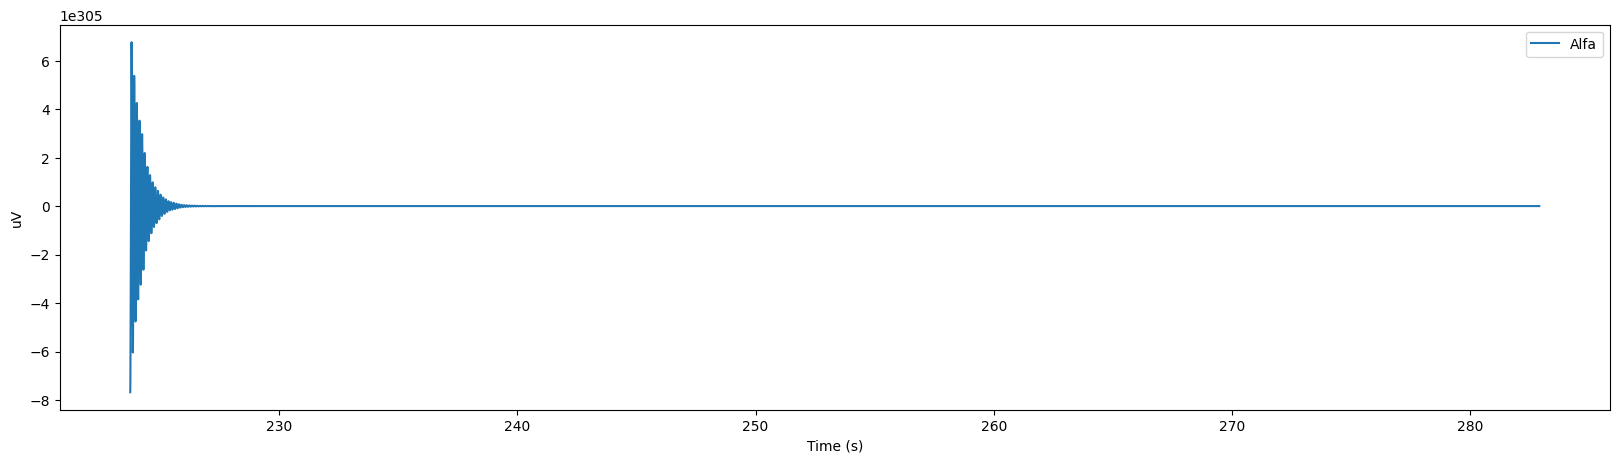

In [21]:
# Extracción de ondas alfa:

low_cutoff_wide = 8
high_cutoff_wide = 12

alfa = butter_bandpass_filter(signal, low_cutoff_wide, high_cutoff_wide, fs)

plt.figure(figsize=(20,5))
plt.plot(time, alfa, label = 'Alfa')
plt.ylabel('uV')
plt.xlabel('Time (s)')
plt.legend()
plt.show()


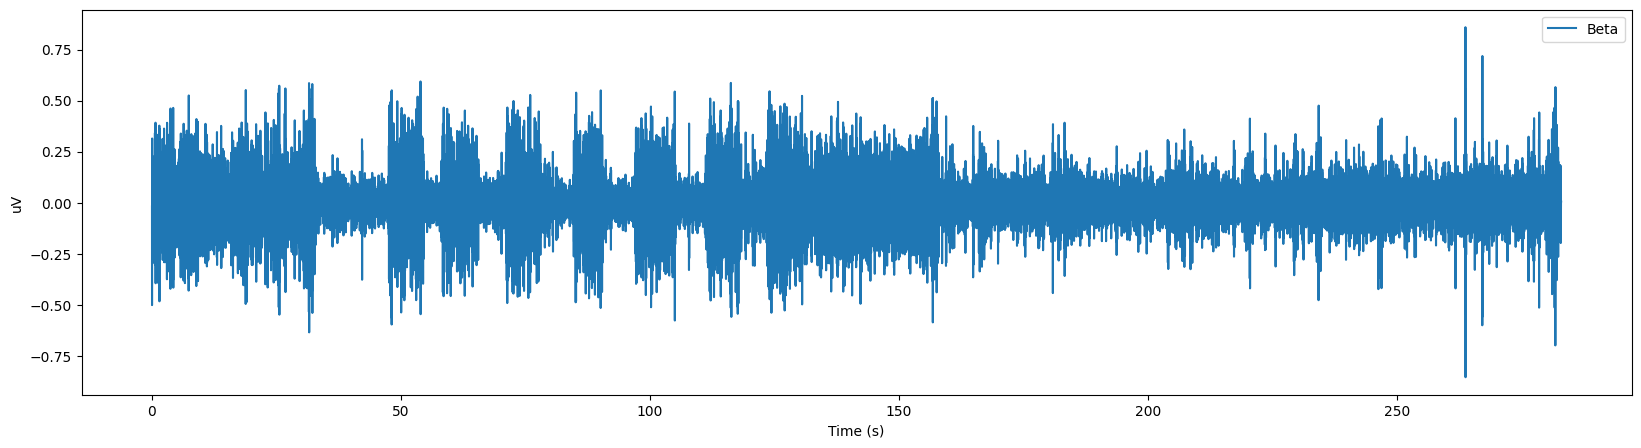

In [22]:
# Extracción de ondas Beta:

low_cutoff_wide = 13
high_cutoff_wide = 30

beta = butter_bandpass_filter(signal, low_cutoff_wide, high_cutoff_wide, fs)

plt.figure(figsize=(20,5))
plt.plot(time, beta, label = 'Beta')
plt.ylabel('uV')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [24]:
# Extraemos las caracteristicas de cada canal:
features = extract_features(filtered_eeg)
features

{'media': -2.800308241052759e-05,
 'desviacion_estandar': 0.23071542377157722,
 'amplitud': 3.4690034396145704,
 'frecuencia_dominante': 957,
 'potencia': 0.05322960755027109,
 'kurtosis': 5.463690542320914,
 'wavelet': array([-0.00187044, -0.00307036,  0.00421085, ..., -0.56040413,
         0.85586905, -0.75752639]),
 'rms': 0.23071542547101417,
 'area': array([ 0.12143809,  0.17915544,  0.17553756, ..., -7.83770108,
        -7.91080403, -7.97155228]),
 'min_value': -1.4860163034045568,
 'max_value': 1.9829871362100133,
 'area_freq': array([0.        , 0.01068079, 0.02587084, 0.03601456, 0.04194134,
        0.04592152, 0.04890665, 0.05091476, 0.05187807, 0.05213114,
        0.05216745, 0.05217129, 0.05217166, 0.0521717 , 0.05217171,
        0.05217172, 0.05217172, 0.05217172, 0.05217172, 0.05217172,
        0.05217172, 0.05217172, 0.05217172, 0.05217172, 0.05217172,
        0.05217172, 0.05217172, 0.05217172, 0.05217172, 0.05217172,
        0.05217172, 0.05217172, 0.05217172, 0.052171